# Calling NucDiff
#### DATE: 02-08-19
#### TASK: 
####       - Call NucDiff on reference file (H37rv) and query file (M. orygis or M. bovis)
####       - Return relevent information in a dataframe

In [4]:
import os, sys, io, random, subprocess
import string
import numpy as np
import pandas as pd
pd.set_option('display.width',150)
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

sys.path.append('/home/tortoise/pybioviz/')
from pybioviz import viewers, utils

import seaborn as sns

In [92]:
# Here, the reference and query genomes are defined. These would be the command line arguments

# Reference genome:
mtb = 'ref_genomes/MTB_h37rv.fna'

# Reference genome annotation file:
mtb_gff = 'MTB.gff'

# Query genomes:
mbovis = 'ref_genomes/mbovis.fna'
mafri = 'ref_genomes/mafricanum.fna'
mcan = 'ref_genomes/mcanettii.fna'
mcap = 'ref_genomes/mcap.fna'
mmic = 'ref_genomes/mmic.fna'
mpin = 'ref_genomes/mpin.fna'
morygis_112400015 = 'ref_genomes/morygis-112400015.fna'
morygis_NIRTAH144 = 'ref_genomes/morygis-NIRTAH144.fna'
morygis_Absc2007 = 'ref_genomes/morygis-Absc2007_spades/morygis-Absc2007.fna'
morygis_Absc2016 = 'ref_genomes/morygis-Absc2016_spades/morygis-Absc2016.fna'
morygis_LN2011 = 'ref_genomes/morygis-LN2011_spades/morygis-LN2011.fna'
morygis_LN2016 = 'ref_genomes/morygis-LN2016_spades/morygis-LN2016.fna'
morygis_Resp2008 = 'ref_genomes/morygis-Resp2008_spades/morygis-Resp2008.fna'
morygis_Resp2011 = 'ref_genomes/morygis-Resp2011_spades/morygis-Resp2011.fna'
morygis_Resp20112 = 'ref_genomes/morygis-Resp20112_spades/morygis-Resp20112.fna'
morygis_Resp2015 = 'ref_genomes/morygis-Resp2015_spades/morygis-Resp2015.fna'

mbovis_05567 = 'ref_genomes/mbovis-05567.fna'
mbovis_1595 = 'ref_genomes/mbovis-1595.fna'
mbovis_BCG1 = 'ref_genomes/mbovis-BCG1.fna'
bovis_Danish1331 = 'ref_genomes/mbovis-Danish1331.fna'    
mbovis_SP38 = 'ref_genomes/mbovis-SP38.fna'
mbovis_091191 = 'ref_genomes/mbovis-091191.fna'
mbovis_20020476 = 'ref_genomes/mbovis-20020476.fna'  
mbovis_BCG1Russia = 'ref_genomes/mbovis-BCG1Russia.fna'
mbovis_DanishdeltasapM = 'ref_genomes/mbovis-DanishdeltasapM.fna'

# Here, the genomes are added to a list for function parsing
# Would be automated using "for arg in sys.argv" loop
genome_list = [mbovis, mafri, mcan, mcap, mmic, mpin, 
               morygis_112400015, morygis_NIRTAH144, morygis_Absc2007, morygis_Absc2016, morygis_LN2011,
               morygis_LN2016, morygis_Resp2008, morygis_Resp2011, morygis_Resp20112, 
               morygis_Resp2015, mbovis_05567, mbovis_1595, mbovis_BCG1, bovis_Danish1331, mbovis_SP38,
               mbovis_091191, mbovis_20020476, mbovis_BCG1Russia, mbovis_DanishdeltasapM]

In [6]:
# Here, a set of features are defined.
# These features are what shall be extracted from inputted gff files, and are used as column headers in the dataframe
# Many titles will return as NaN however allows merging of different features, such as SNPs and Insertions
featurekeys = ['ID', 'Name', 'del_len', 'ins_len', 'query_bases', 'ref_bases', 'query_coord', 'start', 'end']
def features_to_dataframe(features, cds=False):
    """Get features from a biopython seq record object into a dataframe
    Args:
        features: bio seqfeatures
       returns: a dataframe with a row for each cds/entry.
      """

    #preprocess features
    allfeat = []
    for (item, f) in enumerate(features):
        x = f.__dict__
        quals = f.qualifiers
        #print(q)
        x.update(quals)
        d = {}
        d['start'] = f.location.start
        d['end'] = f.location.end
        #d['strand'] = f.location.strand
     
        cols = list(quals.keys())+['start','end']
        for i in quals:
            if i in x:
                if type(x[i]) is list:
                    d[i] = x[i][0]
                else:
                    d[i] = x[i]
        allfeat.append(d)

    df = pd.DataFrame(allfeat,columns=cols)

    return df

In [11]:
quastcmd = 'quast.py -t 8'
for genome in genome_list:
    quastcmd = quastcmd + ' ' + genome
print(quastcmd)

quast.py -t 8 ref_genomes/mbovis.fna ref_genomes/mafricanum.fna ref_genomes/mcanettii.fna ref_genomes/mcap.fna ref_genomes/mmic.fna ref_genomes/mpin.fna ref_genomes/morygis-112400015.fna ref_genomes/morygis-NIRTAH144.fna ref_genomes/morygis-Absc2007_spades/morygis-Absc2007.fna ref_genomes/morygis-Absc2016_spades/morygis-Absc2016.fna ref_genomes/morygis-LN2011_spades/morygis-LN2011.fna ref_genomes/morygis-LN2016_spades/morygis-LN2016.fna ref_genomes/morygis-Resp2008_spades/morygis-Resp2008.fna ref_genomes/morygis-Resp2011_spades/morygis-Resp2011.fna ref_genomes/morygis-Resp20112_spades/morygis-Resp20112.fna ref_genomes/morygis-Resp2015_spades/morygis-Resp2015.fna


In [101]:
# The NucDiff programme is ran in this function
# The function takes in a reference genome and a list of query genomes
# It then performs NucDiff and returns a list of the results folder names for the files
def run_nucdiff(ref, query_list):
    
    # This list will catch the output file names for easier parsing
    outputfolder_list = []
    
    # The list of genomes is iterated over
    for query in query_list:
    
        #The output folder name is defined from the query name
        outfolder = os.path.basename(ref).split('.')[0] + '_' +  os.path.basename(query).split('.')[0]
        
        # The folder name is appended to the list
        # We include '/results' as these are the main dub folder of interest
        outputfolder_list.append(outfolder + '/results')
        
        #The output prefix name is defined from the query name
        outprefix = os.path.basename(query).split('.')[0]

        # The command is defined using nucdiff and the reference genome of MTB, the query genome
        # The command also uses the defined output file name and prefix name
        nucDiffCmd = f'nucdiff {ref} {query} {outfolder} {outprefix}'

        # The command used is printed to screen...
        print (nucDiffCmd)

        # .. checked to see if it has been called yet ..
        if os.path.exists(outfolder):
            
            # .. if so, is skipped
            print('Skipping, previously completed')
        
        # if the output does not exist ..
        else:
            
            # .. it is done
            os.system(nucDiffCmd)
    
    # The folder names are returned
    return outputfolder_list

# The list is passed into the nucdiff calling function
# The list of names of the folders containing the results are captured
nucdiff_results = run_nucdiff(mtb, genome_list)

nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mbovis.fna MTB_h37rv_mbovis mbovis
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mafricanum.fna MTB_h37rv_mafricanum mafricanum
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mcanettii.fna MTB_h37rv_mcanettii mcanettii
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mcap.fna MTB_h37rv_mcap mcap
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mmic.fna MTB_h37rv_mmic mmic
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mpin.fna MTB_h37rv_mpin mpin
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/morygis-112400015.fna MTB_h37rv_morygis-112400015 morygis-112400015
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/morygis-NIRTAH144.fna MTB_h37rv_morygis-NIRTAH144 morygis-NIRTAH144
Skipping, previously completed
nucdiff ref_genomes/MTB_h37rv.fna r

## find common differences morygis and mbovis vs mtb

In [18]:
#read in both gffs from nucdiff

# This extracts the features from a .gff file and returns a dataframe
# This can take in struct.gff, snp.gff and also annotation.gff files
# It then returns a dataframe of the results
def process_gff(gff):
    feats = utils.gff_to_features(gff)
    df = features_to_dataframe(feats)
    df['length'] = df.end - df.start
    df = df[df.Name.notna()]                    
    return df

In [102]:
# This list is defined to catch each struct results df for each file
# The list of dfs is later concated into one df each for all structs results, using a species tag to define origin
structs_list = []

# This list is defined to catch each SNP results df for each file
# The list of dfs is later concated into one df each for all SNP results, using a species tag to define origin
snps_list = []

# We iterate over the results file and extract features
for result_file in nucdiff_results:
    
    # We then iterate over each file in the results..
    for result in os.listdir(result_file):
        
            # .. and only parse the files of interest..
            # Here snp results are viewed, and below structural results are viewed
            if "ref_snps" in result:
                
                # A df is made from the snps.gff file, capturing all features
                snps_df = process_gff(f'{result_file}/{result}')
                
                # The df then has a column added, stating which species it came from, for use in the final df
                snps_df['Species'] = result.split('_')[0]
                
                # The resulting df is then added to the list of dfs, later concated into one df
                snps_list.append(snps_df)

            # The same is done for structural differences as was done for snps
            if "ref_struct" in result:
            
                indels_df = process_gff(f'{result_file}/{result}')
                indels_df['Species'] = result.split('_')[0]
                structs_list.append(indels_df)
                
# Here, the structural results are viewed        
indels = pd.concat(structs_list, sort=True)

# Here, the SNP results are extracted
snps = pd.concat(snps_list, sort=True)

In [103]:
# A pivot table is then made from the indels
# Here, the columns and rows are rearranged, with each indel being grouped by their start position
# This puts together common points of insertion/deltion in each species
# Non-present locations (fill_value) are given a '0'...
start_table = pd.pivot_table(indels, index=['start'], columns=['Species'], aggfunc=np.sum, fill_value = 0)
start_table = start_table.end
# ... and present values are given a '1'
start_table[start_table > 1] = 1

# Here we put just mbovis and morygis into a DF
mor_mbo = start_table.drop(['mcap', 'mpin', 'mcanettii', 'mafricanum', 'mmic'], axis = 1)
mor_mbo = mor_mbo[mor_mbo.sum(1)>0]

# This line only views indels present in more than one species
start_table = start_table[start_table.sum(1)>1]
start_table[:5]

Species,mafricanum,mbovis,mbovis-05567,mbovis-091191,mbovis-1595,mbovis-20020476,mbovis-BCG1,mbovis-BCG1Russia,mbovis-Danish1331,mbovis-DanishdeltasapM,...,morygis-Absc2007,morygis-Absc2016,morygis-LN2011,morygis-LN2016,morygis-NIRTAH144,morygis-Resp2008,morygis-Resp2011,morygis-Resp20112,morygis-Resp2015,mpin
start,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
34787,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,0
34802,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
35208,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
38981,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,1,1,0


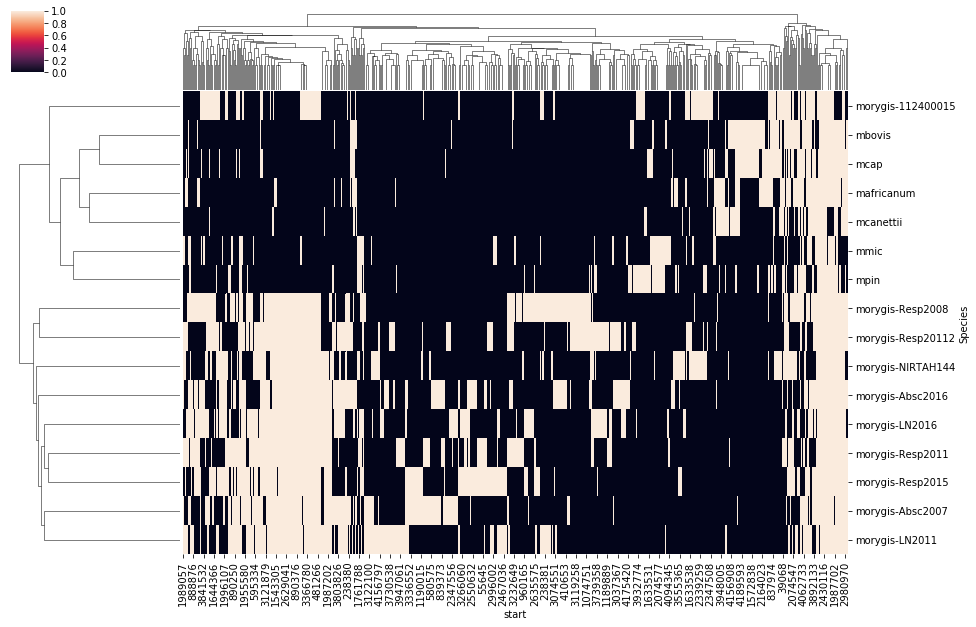

In [22]:
# Here a clustermap is made

g=sns.clustermap(start_table.T, figsize=(15,10))#, cmap="gray_r", lw=1)
g.savefig('clustermap.png',dpi=150)

In [23]:
# A df is made of only the SNPs and not deletions
snps_only = snps[snps.Name == 'substitution']

# The above is then repeated for snps
snp_start_table = pd.pivot_table(snps_only, index=['start'], columns=['Species'], aggfunc=np.sum, fill_value = 0)
snp_start_table[snp_start_table > 1] = 1
snp_start_table = snp_start_table.end[snp_start_table.sum(1)>1]
snp_start_table = snp_start_table[snp_start_table.sum(1)<7]

# A cluster map is then made using the SNPs
#sns.clustermap(snp_start_table.T)
snp_start_table[:5]

Species,mafricanum,mbovis,mcanettii,mcap,mmic,morygis-112400015,morygis-Absc2007,morygis-Absc2016,morygis-LN2011,morygis-LN2016,morygis-NIRTAH144,morygis-Resp2008,morygis-Resp2011,morygis-Resp20112,morygis-Resp2015,mpin
start,,,,,,,,,,,,,,,,
43,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
145,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
466,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1056,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1500,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [24]:
snps_indels_start_table = pd.concat([start_table, snp_start_table])
snps_indels_start_table[:5]
#sns.clustermap(snps_indels_start_table.T)

Species,mafricanum,mbovis,mcanettii,mcap,mmic,morygis-112400015,morygis-Absc2007,morygis-Absc2016,morygis-LN2011,morygis-LN2016,morygis-NIRTAH144,morygis-Resp2008,morygis-Resp2011,morygis-Resp20112,morygis-Resp2015,mpin
start,,,,,,,,,,,,,,,,
0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
34787,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0
34802,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0
35208,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
38981,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0


In [27]:
intersection = mor_mbo[mor_mbo.sum(1)==3]
union = mor_mbo[mor_mbo.sum(1)>0]
only_in_bovis = mor_mbo[(mor_mbo.mbovis == 1) & (mor_mbo.sum(1) == 1)]
only_in_both_orygis = mor_mbo[(mor_mbo.mbovis == 0) & (mor_mbo.sum(1) == 2)]
only_in_one_morygis_strain = mor_mbo[(mor_mbo.mbovis == 0) & (mor_mbo.sum(1) == 1)]
bovis_1124 = mor_mbo[(mor_mbo.mbovis == 1) & (mor_mbo['morygis-112400015'] == 1)]
bovis_NIRT = mor_mbo[(mor_mbo.mbovis == 1) & (mor_mbo['morygis-NIRTAH144'] == 1)]

#print(f'total:{len(mor_mbo)}\nunion:{len(union)}\nintersection:{len(intersection)}\nindels only in mbovis:{len(only_in_bovis)}\
#\nindels only in both morygis:{len(only_in_both_orygis)}\nindels only in one morygis:{len(only_in_one_morygis_strain)}')

In [104]:
########################################################## feats had an entry at the very start stretching the entire genome
#                                                          and was annotated as NaN, which was being assigned
cols=['ID', 'Name', 'Species','length','start','end','gene']
#mtb_feats = utils.gff_to_features(mtb_gff)
#mtb_feats = features_to_dataframe(mtb_feats)

mtb_feats = process_gff(mtb_gff)
#print(mtb_feats[:50])

def get_site_annotations(x):

    feats = mtb_feats
    
    f = feats.Name[((x.start>=feats.start) & (x.start<=feats.end)) |
                  ((x.end>=feats.start) & (x.end<=feats.end)) |
                  ((x.start<=feats.start) & (x.end>=feats.end))]
  
    if(len(f) > 0):
        return f.tolist()
    else:
        return -1


#test56 = indels[:10]
#test56['gene'] = test56.apply(get_site_annotations, 1)

#print(test56['Name','end']

indels['gene'] = indels.apply(get_site_annotations, 1)

#snps['gene'] = snps.apply(get_site_annotations, 1)
#snps[:15]

In [109]:
keep_snps = snps
len(keep_snps)

124259

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


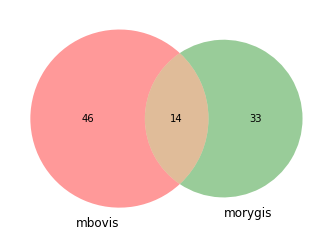

In [112]:
from matplotlib_venn import venn2

# These are the indels of just bovis
mbo = indels[(indels.Species =='mbovis') | (indels.Species == 'mbovis-DanishdeltasapM') | (indels.Species == 'mbovis-BCG1Russia') | 
                        (indels.Species == 'mbovis-20020476') | (indels.Species == 'mbovis-091191') | (indels.Species == 'mbovis-SP38') | 
                        (indels.Species == 'mbovis-Danish1331') | (indels.Species == 'mbovis-BCG1') | (indels.Species == 'mbovis-1595') | 
                        (indels.Species == 'mbovis-05567')]

# These are the indels of all the morygis species
morygis_indels = indels[(indels.Species != 'mbovis') & (indels.Species != 'mbovis-DanishdeltasapM') & (indels.Species != 'mbovis-BCG1Russia') & 
                        (indels.Species != 'mbovis-20020476') & (indels.Species != 'mbovis-091191') & (indels.Species != 'mbovis-SP38') & 
                        (indels.Species != 'mbovis-Danish1331') & (indels.Species != 'mbovis-BCG1') & (indels.Species != 'mbovis-1595') & 
                        (indels.Species != 'mbovis-05567') & (indels.Species != 'mafricanum') & (indels.Species != 'mcanettii') & 
                        (indels.Species != 'mcap') & (indels.Species != 'mmic') & (indels.Species != 'mpin')]




# Here we group by start, and count how often the common start points occur
morygis_indels = morygis_indels.groupby(['start'])['start'].agg({'Frequency':'count'})
mbo = mbo.groupby(['start'])['start'].agg({'Frequency':'count'})

# We then take the set which are present in all species
morygis_indels = morygis_indels[morygis_indels.Frequency == 10]
mbo = mbo[mbo.Frequency == 10]

#morygis_indels.index

venn2((set(mbo.index), set(morygis_indels.index)), set_labels = ('mbovis', 'morygis'))

mbo_mor_starts = set(mbo.index) & set(morygis_indels.index)

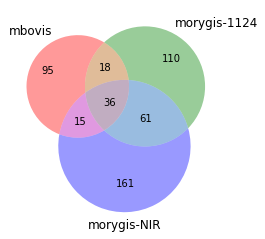

In [87]:
mbo = indels[indels.Species =='mbovis']
mor_1124 = indels[indels.Species =='morygis-112400015']
mor_NIR = indels[indels.Species =='morygis-NIRTAH144']

venn3((set(mbo.start), set(mor_1124.start), set(mor_NIR.start)), set_labels = ('mbovis', 'morygis-1124', 'morygis-NIR'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


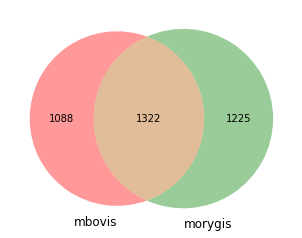

In [120]:
# These are the snps of just bovis
mbo_snps = snps[(snps.Species =='mbovis') | (snps.Species == 'mbovis-DanishdeltasapM') | (snps.Species == 'mbovis-BCG1Russia') | 
                        (snps.Species == 'mbovis-20020476') | (snps.Species == 'mbovis-091191') | (snps.Species == 'mbovis-SP38') | 
                        (snps.Species == 'mbovis-Danish1331') | (snps.Species == 'mbovis-BCG1') | (snps.Species == 'mbovis-1595') | 
                        (snps.Species == 'mbovis-05567')]

# These are the snps of all the morygis species
morygis_snps = snps[(snps.Species != 'mbovis') & (snps.Species != 'mbovis-DanishdeltasapM') & (snps.Species != 'mbovis-BCG1Russia') & 
                        (snps.Species != 'mbovis-20020476') & (snps.Species != 'mbovis-091191') & (snps.Species != 'mbovis-SP38') & 
                        (snps.Species != 'mbovis-Danish1331') & (snps.Species != 'mbovis-BCG1') & (snps.Species != 'mbovis-1595') & 
                        (snps.Species != 'mbovis-05567') & (snps.Species != 'mafricanum') & (snps.Species != 'mcanettii') & 
                        (snps.Species != 'mcap') & (snps.Species != 'mmic') & (snps.Species != 'mpin')]

# Here we group by start, and count how often the common start points occur
morygis_snps = morygis_snps.groupby(['start'])['start'].agg({'Frequency':'count'})
mbo_snps = mbo_snps.groupby(['start'])['start'].agg({'Frequency':'count'})

# We then take the set which are present in all species
morygis_snps = morygis_snps[morygis_snps.Frequency == 10]
mbo_snps = mbo_snps[mbo_snps.Frequency == 10]

#morygis_indels.index

venn2((set(mbo_snps.index), set(morygis_snps.index)), set_labels = ('mbovis', 'morygis'))

mbo_mor_snps = set(mbo_snps.index) & set(morygis_snps.index)

In [117]:
mbovis_alone = indels[indels.Species == 'mbovis']
common = mbovis_alone[mbovis_alone.start.isin(mbo_mor_starts)]
common.columns
cols=['ID', 'Name', 'Species', 'length','start','end','gene']
common[cols]

,ID,Name,Species,length,start,end,gene
5,SV_6,deletion,mbovis,1902,264754,266656,"[Rv0221, echA1, Rv0223c]"
19,SV_20,insertion,mbovis,1,742633,742634,-1
78,SV_78.1,relocation,mbovis,1,2208004,2208005,[yrbE3A]
79,SV_78.2,relocation,mbovis,1,2220724,2220725,[Rv1977]
82,SV_81,deletion,mbovis,2028,2330073,2332101,"[cobL, Rv2073c, Rv2074, Rv2075c]"
85,SV_84,deletion,mbovis,1354,2365414,2366768,-1
86,SV_85,collapsed_repeat,mbovis,4,2366768,2366772,-1
96,SV_95,deletion,mbovis,1353,2550013,2551366,[Rv2277c]
103,SV_102,deletion,mbovis,1353,2784616,2785969,-1
106,SV_105.1,relocation-overlap,mbovis,1,2970015,2970016,-1


In [122]:
# Here the RD df is read in

def find_regions(data):
    """match regions of difference"""
    
    RD = pd.read_csv('RD.csv', comment='#')
    found=[]
    for i,r in data.iterrows():
        df = RD[((r.start>RD.Start) & (r.start<RD.Stop)) |
                  ((r.end>RD.Start) & (r.end<RD.Stop)) |
                  ((r.start<RD.Start) & (r.end>RD.Stop))]
        #df = RD[abs(RD.Start-r.start)<500]
        if len(df) > 0:
            #print (df)
            #print (r)
            df['indel_start'] = r.start
            df['indel_end'] = r.end
            df['name'] = r.Name
            df['del_len'] = r.end-r.start
            found.append(df)

    found = pd.concat(found)
    return found

#mb = find_regions(mbovis_indels_df)
#mo = find_regions(morygis_indels_df)
#mbmo = find_regions(common_indels)

#print (len(mb),len(mo))

x = find_regions(common)
print(x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

   RD_name    Start     Stop   Size             Rv  indel_start  indel_end        name  del_len
30    RD10   264067   267764   3697  Rv0221-Rv0223       264754     266656    deletion     1902
27     RD7  2207700  2220800  13100  Rv1964-Rv1977      2208004    2208005  relocation        1
27     RD7  2207700  2220800  13100  Rv1964-Rv1977      2220724    2220725  relocation        1
29     RD9  2328974  2332879   3905    CobL-Rv2075      2330073    2332101    deletion     2028
12   RD182  2545194  2551674   6481    Rv2270-2280      2550013    2551366    deletion     1353
28     RD8  4057733  4063249   5516      EphA-lpqG      4056840    4062733    deletion     5893


In [9]:
set(mb.RD_name) & set(mo.RD_name)

{'RD10', 'RD11', 'RD14', 'RD182', 'RD207', 'RD5', 'RD7', 'RD8', 'RD9'}

In [ ]:
mb.sort_values('del_len')

In [11]:
#RD5:   NC_000962.3:2,625,888-2,635,592  Similar         (Not flagged as same)
#RD10:  NC_000962.3:264,067-267,764      Common
#RD9:   NC_000962.3:2,328,974-2,332,879  Common
#RD8    NC_000962.3:4,053,166-4,066,581  Common

In [12]:
mbmo

,RD_name,Start,Stop,Size,Rv,indel_start,indel_end,name,del_len
30,RD10,264067,267764,3697,Rv0221-Rv0223,264754,266656,deletion,1902
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2208004,2208005,relocation,1
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2220724,2220725,relocation,1
29,RD9,2328974,2332879,3905,CobL-Rv2075,2330073,2332101,deletion,2028
28,RD8,4057733,4063249,5516,EphA-lpqG,4056840,4062733,deletion,5893
